# India ML Hiring Hackathon 2019 - LOAN DEFAULTER PREDICTION

###### IMPORTING NECESSARY MODULES

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
os.chdir("F:\\PROJECTS\\Hackathons\\AV_INDEPENDENCE")

In [3]:
train = pd.read_csv("train.csv")

In [4]:
train.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,3,4,5,6,7,8,9,10,11,1


In [5]:
train.columns

Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13'],
      dtype='object')

In [6]:
train['m13'] = train['m13'].astype('bool')

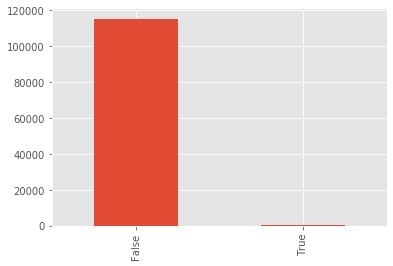

In [7]:
train['m13'].value_counts().plot(kind = 'bar')
plt.show()

In [8]:
train['number_of_borrowers'] = train['number_of_borrowers'].map({1.0:1,2.0:2})

cols_to_convert = ['loan_id', 'financial_institution', 'loan_purpose','insurance_type','number_of_borrowers']
train[cols_to_convert] = train[cols_to_convert].astype('category', ordered = False)

train['m13'].value_counts(normalize = True)

False    0.99452
True     0.00548
Name: m13, dtype: float64

##### MAKING NEW FEATURES

In [9]:
pd.crosstab(pd.cut(train.unpaid_principal_bal, bins = 2, labels = ["low","high"]), train['m13'])

m13,False,True
unpaid_principal_bal,,
low,114869,635
high,553,1


Loans with low unpaid balance has more defaulters. So making a feature out of it.

In [10]:
train['loan_to_cat'] = pd.cut(train.unpaid_principal_bal, bins = 2, labels = ["low","high"])

In [11]:
pd.crosstab(pd.cut(train.loan_to_value, bins = 3, labels = ["low","big","high"]), train.m13)

m13,False,True
loan_to_value,,
low,7709,28
big,37189,150
high,70524,458


Loans with High Loan to value ratio has more defaulters. So, adding this as a feature.

In [12]:
train['loan_to_val_cat'] = pd.cut(train.loan_to_value, bins = 3, labels = ["low","big","high"])

In [13]:
pd.crosstab(pd.cut(train.debt_to_income_ratio, bins = 3, labels = ['low','big','high']), train.m13)

m13,False,True
debt_to_income_ratio,,
low,26414,58
big,77864,462
high,11144,116


People with medium and high debt_to_income_ratio has more number of defaulters. So, adding a feature out of it.

In [14]:
train['debt_to_income_cat'] = pd.cut(train.debt_to_income_ratio, bins = 3, labels = ['low','big','high'])

In [15]:
train['insurance_type'] = train['insurance_type'].map({0.0:0,1.0:1})

Calculating total deliquency in over all months.

In [16]:
train['total_deliquency_in_months'] = train.loc[:,'m1':'m12'].sum(axis = 'columns')

Wether a feature is deliquent or not:

In [17]:
train['is_deliquent'] = train['total_deliquency_in_months'] > 0

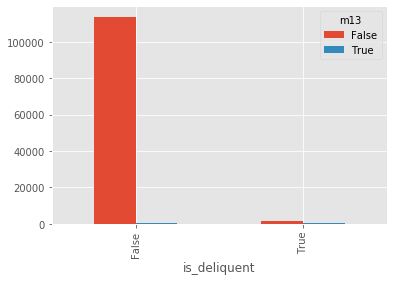

In [18]:
pd.crosstab(train['is_deliquent'], train['m13']).plot(kind = 'bar')
plt.show()

Making boorower_credit_performance feature as categorical, according to credit scores from some financial websites.

In [19]:
def credit_performance(col):
    if col >= 800:
        return 'exceptional'
    elif col < 800 and col >= 670:
        return 'good'
    else:
        return 'poor'

In [20]:
train['borrower_credit_performance'] = train.borrower_credit_score.apply(credit_performance).astype('category')

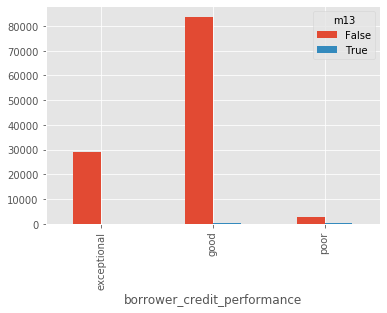

In [21]:
pd.crosstab(train['borrower_credit_performance'], train['m13']).plot(kind = 'bar')
plt.show()

In [22]:
pd.crosstab(train.financial_institution, train.m13)

m13,False,True
financial_institution,,
Anderson-Taylor,480,3
Browning-Hart,31677,175
Chapman-Mcmahon,388,0
"Cole, Brooks and Vincent",1630,12
Edwards-Hoffman,4816,41
"Martinez, Duffy and Bird",4692,23
"Miller, Mcclure and Allen",3139,19
Nicholson Group,2105,11
OTHER,49430,269


In [23]:
m_cols = ['m'+str(num+1) for num in range(13)]

##### DROPPING UNECESSARY FEATURES

In [24]:
train.drop('co-borrower_credit_score', axis = 'columns', inplace = True)

In [25]:
train.drop(['first_payment_date', 'origination_date'], axis ='columns', inplace = True)

In [26]:
train.drop('insurance_type', axis = 'columns', inplace = True)

In [27]:
train.drop('loan_id', axis = 'columns', inplace = True)

In [28]:
train.drop('loan_purpose', axis = 'columns', inplace = True)

In [29]:
train.drop('total_deliquency_in_months', axis = 'columns', inplace = True)

In [30]:
train.drop(['unpaid_principal_bal','borrower_credit_score','debt_to_income_ratio','loan_to_value','loan_term','number_of_borrowers','m2','m4','m6','m8'], 
           axis = 'columns', inplace = True)

In [31]:
numeric_cols = [col for col in train.columns if train[col].dtype == 'int64' or train[col].dtype == 'float64']
numeric_cols

['interest_rate',
 'insurance_percent',
 'm1',
 'm3',
 'm5',
 'm7',
 'm9',
 'm10',
 'm11',
 'm12']

In [32]:
target = train['m13']
train.drop('m13', axis = 'columns', inplace = True)

##### SCALING NUMERIC FEATURES

In [33]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(train[numeric_cols])
train[numeric_cols] = scaler.transform(train[numeric_cols])

In [34]:
cat_cols = [col for col in train.columns if train[col].dtype not in ['int64','float64','bool']]
cat_cols

['source',
 'financial_institution',
 'loan_to_cat',
 'loan_to_val_cat',
 'debt_to_income_cat',
 'borrower_credit_performance']

##### ONE-HOT ENCODING CATEGORICAL FEATURES

In [35]:
train_cat = train[cat_cols]

In [36]:
train_cat = pd.get_dummies(train_cat, prefix_sep = '_', drop_first = True)

In [37]:
train = pd.concat([train, train_cat], axis = 'columns')

In [38]:
train.drop(cat_cols, axis = 'columns', inplace = True)

##### PRE-PROCESSING TEST DATA

In [39]:
def pre_proecess(data, cols_to_convert, numeric_cols, cat_cols, m_cols, scaler):
    
    '''
    Pre-Processing test data as the same as train data;
    '''
    
    ###########New Columns##################
    data['loan_to_cat'] = pd.cut(data.unpaid_principal_bal, bins = 2, labels = ["low","high"])
    data['loan_to_val_cat'] = pd.cut(data.loan_to_value, bins = 3, labels = ["low","big","high"])
    data['debt_to_income_cat'] = pd.cut(data.debt_to_income_ratio, bins = 3, labels = ['low','big','high'])
    data['insurance_type'] = data['insurance_type'].map({0.0:0,1.0:1})
    data['total_deliquency_in_months'] = data.loc[:,'m1':'m12'].sum(axis = 'columns')
    data['is_deliquent'] = data['total_deliquency_in_months'] > 0
    data['borrower_credit_performance'] = data.borrower_credit_score.apply(credit_performance).astype('category')
    
    ##########Column data type conversion########
    data[cols_to_convert] = data[cols_to_convert].astype('category', ordered = False)
    
    ##########Dropping unnecssary columns########
    data.drop(['first_payment_date', 'origination_date','loan_purpose',
               'loan_term'], axis ='columns', inplace = True)
    data.drop('insurance_type', axis = 'columns', inplace = True)
    data.drop('co-borrower_credit_score', axis = 'columns', inplace = True)
    data.drop('total_deliquency_in_months', axis = 'columns', inplace = True)
    data.drop(['unpaid_principal_bal','borrower_credit_score','debt_to_income_ratio','loan_to_value', 'number_of_borrowers','m2','m4','m6','m8'], 
               axis = 'columns', inplace = True)
    
    ###########Scaling and One-Hot Encoding#######
    data[numeric_cols] = scaler.transform(data[numeric_cols])
    data_cat = data[cat_cols]
    data_cat = pd.get_dummies(data_cat, prefix_sep = '_', drop_first = True)
    data = pd.concat([data, data_cat], axis = 'columns')
    data.drop(cat_cols, axis = 'columns', inplace = True)
    
    return data

##### MODEL BUILDING

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size = 0.30, random_state = 45)

##### OVER-SAMPLING MINORITY CLASS USING SMOTE

In [42]:
from imblearn.over_sampling import SMOTE
import xgboost as xgb

Using TensorFlow backend.


In [43]:
smt = SMOTE(k_neighbors = 5,ratio = 0.15, sampling_strategy='svm')

In [44]:
smt

SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
      out_step='deprecated', random_state=None, ratio=0.15,
      sampling_strategy='svm', svm_estimator='deprecated')

In [45]:
X_train, y_train = smt.fit_sample(X_train, y_train)

In [46]:
np.bincount(y_train)

array([80800, 12120], dtype=int64)

##### XGBOOST CLASSIFIER

In [47]:
xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
X_val = X_val.values

In [49]:
from sklearn.metrics import confusion_matrix, f1_score

##### PERFORMANCE ON VALIDATION DATA

In [50]:
xg_preds = xg_clf.predict(X_val)
confusion_matrix(y_val, xg_preds)

array([[34556,    66],
       [   96,   100]], dtype=int64)

In [51]:
xg_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [52]:
f1_score(y_val, xg_preds)

0.5524861878453039

##### PREDICTIONS ON TEST DATA AND SUBMISSION

In [53]:
test = pd.read_csv("test.csv")

test_df = pre_proecess(test, cols_to_convert, numeric_cols, cat_cols, m_cols, scaler)

In [54]:
list(set(train.columns) - set(test_df.columns))

[]

In [55]:
test_df['m13'] = xg_clf.predict(test_df.drop('loan_id', axis = 'columns').values)

In [56]:
sub = test_df[['loan_id', 'm13']]
sub['m13'] = sub['m13'].map({True:1,False:0})
sub.to_csv("submission_file.csv", index = False)

C:\Users\Chinna\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### COMPUTING PERMUTATION IMPORTANCE ON MODEL BUILT

In [57]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xg_clf, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = train.columns.tolist())

Weight,Feature
0.0010 ± 0.0002,is_deliquent
0.0004 ± 0.0001,m12
0.0000 ± 0.0001,borrower_credit_performance_good
0.0000 ± 0.0000,debt_to_income_cat_high
0.0000 ± 0.0001,source_Z
0.0000 ± 0.0000,loan_to_val_cat_big
0.0000 ± 0.0001,debt_to_income_cat_big
0.0000 ± 0.0000,"financial_institution_Swanson, Newton and Miller"
0.0000 ± 0.0000,"financial_institution_Taylor, Hunt and Rodriguez"
0 ± 0.0000,financial_institution_Nicholson Group
